# Representation Jensen-Rényi Divergence Variational Autoencoder
In thi notebook, we provide the code to replicate the results of the experiment where an InfoVAE is trained with the Jensen-Rényi divergence.

> J. K. Hoyos Osorio, O. Skean, A. J. Brockmeier and L. G. Sanchez Giraldo, "The Representation Jensen-Rényi Divergence," ICASSP 2022 - 2022 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), 2022, pp. 4313-4317, doi: 10.1109/ICASSP43922.2022.9747350.

In this experiement, we compare the classification accuracy with the one obtained with an Maximum Mean Discrepancy.
The code below is based on https://github.com/ShengjiaZhao/MMD-Variational-Autoencoder/blob/master/mmd_vae.ipynb, which is based on the paper:

> Zhao, S., Song, J., & Ermon, S. (2017). InfoVAE: Information Maximizing Variational Autoencoders. ArXiv, abs/1706.02262.



In [76]:
import torch
from torch.autograd import Variable

from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms

import numpy as np
from matplotlib import pyplot as plt
import math, os
import sys

import repitl.kernel_utils as ku
import repitl.matrix_itl as itl
import repitl.divergences as div

In [89]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

# Encoder and decoder use the DC-GAN architecture
class Encoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Conv2d(1, 64, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            Flatten(),
            torch.nn.Linear(6272, 1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, z_dim)
        ])
        
    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x
    
    
class Decoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Linear(z_dim, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 7*7*128),
            torch.nn.ReLU(),
            Reshape((128,7,7,)),
            torch.nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 1, 4, 2, padding=1),
            torch.nn.Sigmoid()
        ])
        
    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x



In [140]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x[:,None,:] # (x_size, 1, dim)
    y = y[None, :,:] # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(-1)/float(dim)
    return torch.exp(-kernel_input) 

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

def matrixJRDivergence(x, y):
    alpha = 1.01
    sigma = np.sqrt(x.shape[1]/2)
    return div.divergenceJR(x, y, sigma, alpha)

In [141]:
class Model(torch.nn.Module):
    def __init__(self, z_dim):
        super(Model, self).__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        
    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed

In [142]:
# Convert a numpy array of shape [batch_size, height, width, 1] into a displayable array 
# of shape [height*sqrt(batch_size, width*sqrt(batch_size))] by tiling the images
def convert_to_display(samples):
    cnt, height, width = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2]
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width])
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height*cnt, width*cnt])
    return samples


def trainInfoVAE(
    dataloader,
    divergence_func=compute_mmd,
    tradeoff=1.0,
    z_dim=2,
    n_epochs=10,
    use_cuda=True,
    print_every=100,
    plot_every=500
):
    model = Model(z_dim)
    if use_cuda:
        model = model.cuda()
    optimizer = torch.optim.Adam(model.parameters())
    i = -1
    for epoch in range(n_epochs):
        for images, labels in dataloader:
            i += 1
            optimizer.zero_grad()
            x = Variable(images, requires_grad=False)
            true_samples = Variable(
                torch.randn(200, z_dim),
                requires_grad=False
            )
            if use_cuda:
                x = x.cuda()
                true_samples = true_samples.cuda()
            z, x_reconstructed = model(x)
            div = divergence_func(true_samples, z)
            nll = (x_reconstructed - x).pow(2).mean()
            loss = nll + tradeoff * div
            loss.backward()
            optimizer.step()
            if i % print_every == 0:
                print("Negative log likelihood is {:.5f}, divergence loss is {:.5f}".format(
                    nll.item(), div.item()))
            if i % plot_every == 0:
                gen_z = Variable(
                    torch.randn(100, z_dim),
                    requires_grad=False
                )
                if use_cuda:
                    gen_z = gen_z.cuda()
                samples = model.decoder(gen_z)
                samples = samples.permute(0,2,3,1).contiguous().cpu().data.numpy()
                plt.imshow(convert_to_display(samples), cmap='Greys_r')
                plt.show()
                
    return model

## Train on MNIST

In [143]:
batch_size=200
mnist_train = torch.utils.data.DataLoader(
    MNIST("./tmp/MNIST", train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True, num_workers=3,
    pin_memory=True
)

Negative log likelihood is 0.24075, divergence loss is 0.01082


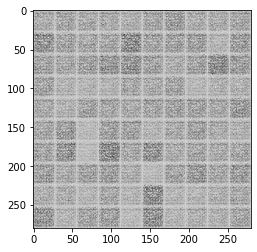

Negative log likelihood is 0.03553, divergence loss is 0.00694
Negative log likelihood is 0.01869, divergence loss is 0.00751
Negative log likelihood is 0.01629, divergence loss is 0.00334
Negative log likelihood is 0.01521, divergence loss is 0.00265
Negative log likelihood is 0.01397, divergence loss is 0.00241


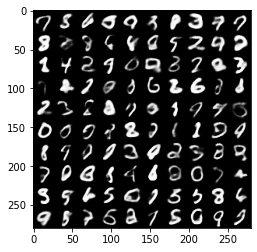

Negative log likelihood is 0.01352, divergence loss is 0.00170
Negative log likelihood is 0.01221, divergence loss is 0.00103
Negative log likelihood is 0.01157, divergence loss is 0.00378
Negative log likelihood is 0.01176, divergence loss is 0.00227
Negative log likelihood is 0.01127, divergence loss is 0.00133


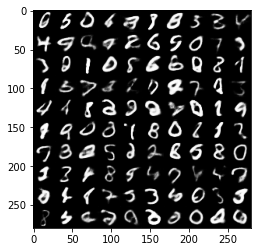

Negative log likelihood is 0.01170, divergence loss is 0.00195
Negative log likelihood is 0.01049, divergence loss is 0.00105
Negative log likelihood is 0.01021, divergence loss is 0.00161
Negative log likelihood is 0.01080, divergence loss is 0.00278
Negative log likelihood is 0.01051, divergence loss is 0.00152


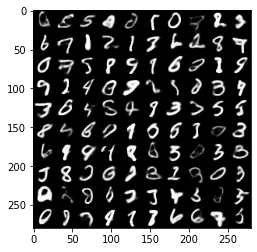

Negative log likelihood is 0.01034, divergence loss is 0.00238
Negative log likelihood is 0.00985, divergence loss is 0.00336
Negative log likelihood is 0.01036, divergence loss is 0.00296
Negative log likelihood is 0.00987, divergence loss is 0.00209
Negative log likelihood is 0.01049, divergence loss is 0.00204


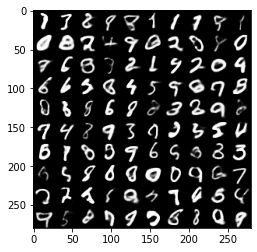

Negative log likelihood is 0.00937, divergence loss is 0.00181
Negative log likelihood is 0.00962, divergence loss is 0.00170
Negative log likelihood is 0.00999, divergence loss is 0.00138
Negative log likelihood is 0.00923, divergence loss is 0.00107
Negative log likelihood is 0.00854, divergence loss is 0.00289


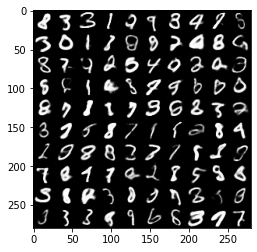

Negative log likelihood is 0.00932, divergence loss is 0.00239
Negative log likelihood is 0.00877, divergence loss is 0.00202
Negative log likelihood is 0.00896, divergence loss is 0.00144
Negative log likelihood is 0.00868, divergence loss is 0.00328
Negative log likelihood is 0.00858, divergence loss is 0.00176


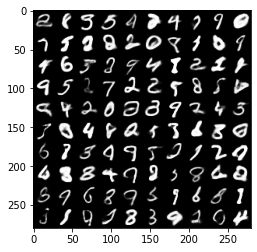

Negative log likelihood is 0.00880, divergence loss is 0.00251
Negative log likelihood is 0.00880, divergence loss is 0.00176
Negative log likelihood is 0.00852, divergence loss is 0.00216
Negative log likelihood is 0.00958, divergence loss is 0.00319
Negative log likelihood is 0.00852, divergence loss is 0.00177


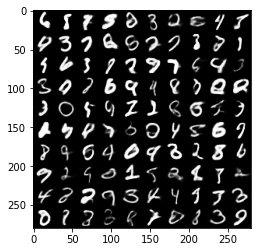

Negative log likelihood is 0.00908, divergence loss is 0.00176
Negative log likelihood is 0.00801, divergence loss is 0.00145
Negative log likelihood is 0.00887, divergence loss is 0.00111
Negative log likelihood is 0.00784, divergence loss is 0.00142
Negative log likelihood is 0.00845, divergence loss is 0.00246


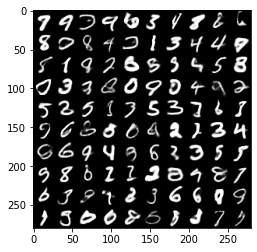

Negative log likelihood is 0.00836, divergence loss is 0.00274
Negative log likelihood is 0.00798, divergence loss is 0.00229
Negative log likelihood is 0.00862, divergence loss is 0.00496
Negative log likelihood is 0.00751, divergence loss is 0.00534
Negative log likelihood is 0.00784, divergence loss is 0.00149


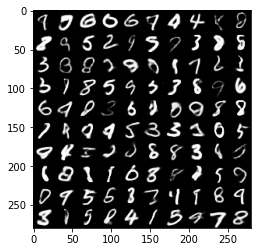

Negative log likelihood is 0.00832, divergence loss is 0.00132
Negative log likelihood is 0.00765, divergence loss is 0.00139
Negative log likelihood is 0.00744, divergence loss is 0.00310
Negative log likelihood is 0.00771, divergence loss is 0.00220
Negative log likelihood is 0.00783, divergence loss is 0.00113


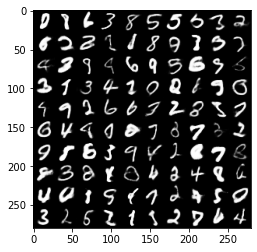

Negative log likelihood is 0.00760, divergence loss is 0.00125
Negative log likelihood is 0.00730, divergence loss is 0.00314
Negative log likelihood is 0.00693, divergence loss is 0.00143
Negative log likelihood is 0.00716, divergence loss is 0.00141
Negative log likelihood is 0.00781, divergence loss is 0.00160


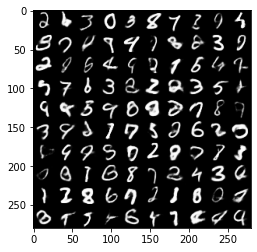

Negative log likelihood is 0.00782, divergence loss is 0.00162
Negative log likelihood is 0.00734, divergence loss is 0.00094
Negative log likelihood is 0.00754, divergence loss is 0.00176
Negative log likelihood is 0.00753, divergence loss is 0.00113
Negative log likelihood is 0.00747, divergence loss is 0.00167


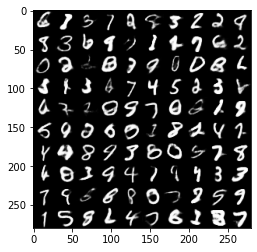

Negative log likelihood is 0.00762, divergence loss is 0.00104
Negative log likelihood is 0.00725, divergence loss is 0.00140
Negative log likelihood is 0.00726, divergence loss is 0.00128
Negative log likelihood is 0.00789, divergence loss is 0.00097
Negative log likelihood is 0.00743, divergence loss is 0.00189


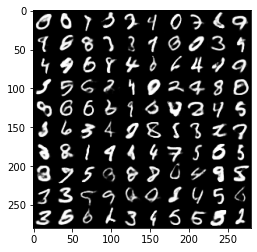

Negative log likelihood is 0.00779, divergence loss is 0.00218
Negative log likelihood is 0.00750, divergence loss is 0.00240
Negative log likelihood is 0.00700, divergence loss is 0.00293
Negative log likelihood is 0.00725, divergence loss is 0.00282
Negative log likelihood is 0.00742, divergence loss is 0.00200


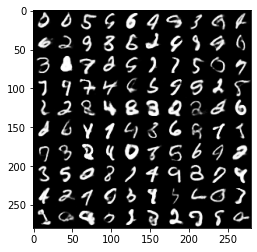

Negative log likelihood is 0.00755, divergence loss is 0.00152
Negative log likelihood is 0.00773, divergence loss is 0.00205
Negative log likelihood is 0.00727, divergence loss is 0.00163
Negative log likelihood is 0.00773, divergence loss is 0.00190
Negative log likelihood is 0.00702, divergence loss is 0.00085


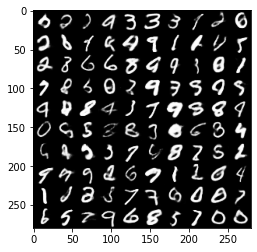

Negative log likelihood is 0.00687, divergence loss is 0.00226
Negative log likelihood is 0.00738, divergence loss is 0.00132
Negative log likelihood is 0.00749, divergence loss is 0.00270
Negative log likelihood is 0.00738, divergence loss is 0.00152
Negative log likelihood is 0.00622, divergence loss is 0.00145


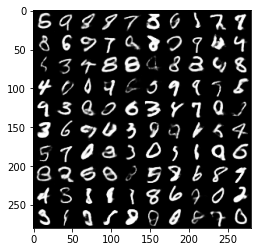

Negative log likelihood is 0.00742, divergence loss is 0.00219
Negative log likelihood is 0.00717, divergence loss is 0.00176
Negative log likelihood is 0.00687, divergence loss is 0.00214
Negative log likelihood is 0.00731, divergence loss is 0.00173
Negative log likelihood is 0.00681, divergence loss is 0.00282


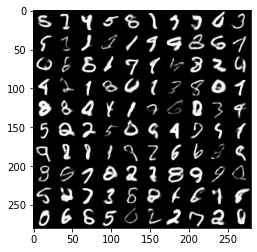

Negative log likelihood is 0.00689, divergence loss is 0.00296
Negative log likelihood is 0.00713, divergence loss is 0.00158
Negative log likelihood is 0.00743, divergence loss is 0.00178
Negative log likelihood is 0.00709, divergence loss is 0.00146
Negative log likelihood is 0.00750, divergence loss is 0.00162


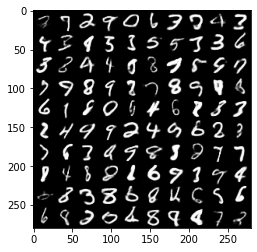

Negative log likelihood is 0.00699, divergence loss is 0.00178
Negative log likelihood is 0.00712, divergence loss is 0.00176
Negative log likelihood is 0.00693, divergence loss is 0.00194
Negative log likelihood is 0.00715, divergence loss is 0.00161
Negative log likelihood is 0.00677, divergence loss is 0.00102


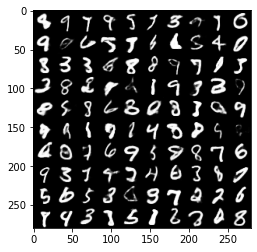

Negative log likelihood is 0.00618, divergence loss is 0.00208
Negative log likelihood is 0.00713, divergence loss is 0.00117
Negative log likelihood is 0.00714, divergence loss is 0.00112
Negative log likelihood is 0.00713, divergence loss is 0.00177
Negative log likelihood is 0.00681, divergence loss is 0.00241


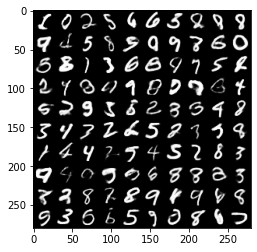

Negative log likelihood is 0.00693, divergence loss is 0.00164
Negative log likelihood is 0.00692, divergence loss is 0.00122
Negative log likelihood is 0.00675, divergence loss is 0.00354
Negative log likelihood is 0.00676, divergence loss is 0.00308
Negative log likelihood is 0.00690, divergence loss is 0.00466


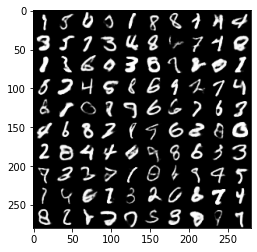

Negative log likelihood is 0.00659, divergence loss is 0.00102
Negative log likelihood is 0.00689, divergence loss is 0.00271
Negative log likelihood is 0.00693, divergence loss is 0.00141
Negative log likelihood is 0.00727, divergence loss is 0.00148
Negative log likelihood is 0.00682, divergence loss is 0.00204


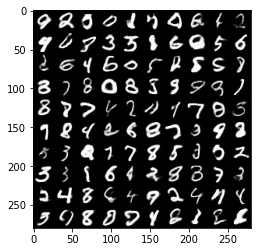

Negative log likelihood is 0.00677, divergence loss is 0.00158
Negative log likelihood is 0.00653, divergence loss is 0.00223
Negative log likelihood is 0.00650, divergence loss is 0.00227
Negative log likelihood is 0.00659, divergence loss is 0.00175
Negative log likelihood is 0.00688, divergence loss is 0.00171


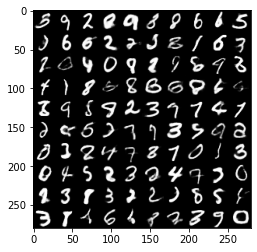

Negative log likelihood is 0.00691, divergence loss is 0.00226
Negative log likelihood is 0.00620, divergence loss is 0.00154
Negative log likelihood is 0.00673, divergence loss is 0.00246
Negative log likelihood is 0.00637, divergence loss is 0.00171


In [160]:
# train MMD Baseline
z_dim = 10
mmd_model = trainInfoVAE(mnist_train,
                         z_dim=z_dim, 
                         n_epochs=20)



Negative log likelihood is 0.22698, divergence loss is 0.44963


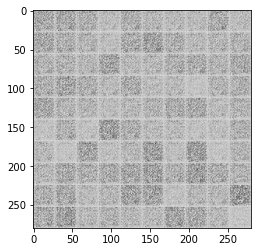

Negative log likelihood is 0.03400, divergence loss is 0.31956
Negative log likelihood is 0.02149, divergence loss is 0.22112
Negative log likelihood is 0.01729, divergence loss is 0.22652
Negative log likelihood is 0.01456, divergence loss is 0.21990
Negative log likelihood is 0.01446, divergence loss is 0.20927


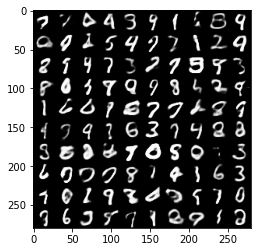

Negative log likelihood is 0.01323, divergence loss is 0.22403
Negative log likelihood is 0.01313, divergence loss is 0.21199
Negative log likelihood is 0.01295, divergence loss is 0.23597
Negative log likelihood is 0.01150, divergence loss is 0.21750
Negative log likelihood is 0.01115, divergence loss is 0.22902


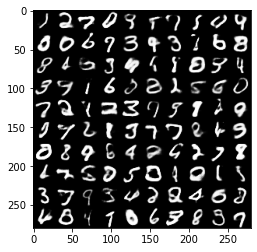

Negative log likelihood is 0.01255, divergence loss is 0.22369
Negative log likelihood is 0.01097, divergence loss is 0.20791
Negative log likelihood is 0.01161, divergence loss is 0.23258
Negative log likelihood is 0.01196, divergence loss is 0.21763
Negative log likelihood is 0.01021, divergence loss is 0.22262


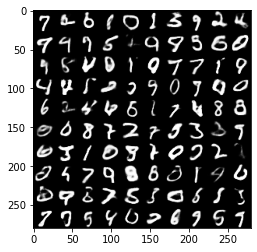

Negative log likelihood is 0.01083, divergence loss is 0.21605
Negative log likelihood is 0.01002, divergence loss is 0.22835
Negative log likelihood is 0.01032, divergence loss is 0.20489
Negative log likelihood is 0.01033, divergence loss is 0.21969
Negative log likelihood is 0.00981, divergence loss is 0.23780


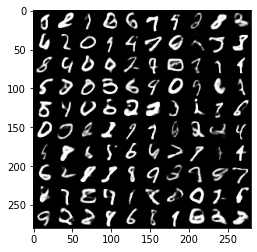

Negative log likelihood is 0.01042, divergence loss is 0.21247
Negative log likelihood is 0.01030, divergence loss is 0.21959
Negative log likelihood is 0.00909, divergence loss is 0.21442
Negative log likelihood is 0.01007, divergence loss is 0.20090
Negative log likelihood is 0.00942, divergence loss is 0.21076


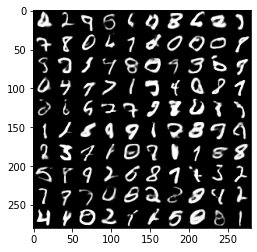

Negative log likelihood is 0.00937, divergence loss is 0.22767
Negative log likelihood is 0.00947, divergence loss is 0.20198
Negative log likelihood is 0.00857, divergence loss is 0.23237
Negative log likelihood is 0.00999, divergence loss is 0.21532
Negative log likelihood is 0.00923, divergence loss is 0.22564


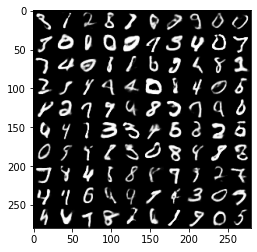

Negative log likelihood is 0.00945, divergence loss is 0.21916
Negative log likelihood is 0.00917, divergence loss is 0.20599
Negative log likelihood is 0.00931, divergence loss is 0.20403
Negative log likelihood is 0.00894, divergence loss is 0.21160
Negative log likelihood is 0.00847, divergence loss is 0.21836


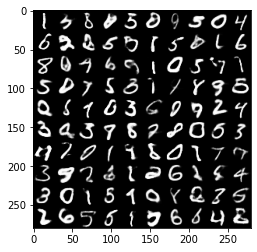

Negative log likelihood is 0.00935, divergence loss is 0.19984
Negative log likelihood is 0.00853, divergence loss is 0.23097
Negative log likelihood is 0.00862, divergence loss is 0.20662
Negative log likelihood is 0.00872, divergence loss is 0.22322
Negative log likelihood is 0.00914, divergence loss is 0.21279


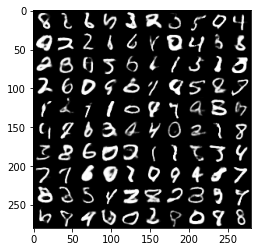

Negative log likelihood is 0.00926, divergence loss is 0.22508
Negative log likelihood is 0.00901, divergence loss is 0.22227
Negative log likelihood is 0.00924, divergence loss is 0.22757
Negative log likelihood is 0.00862, divergence loss is 0.21396
Negative log likelihood is 0.00834, divergence loss is 0.21752


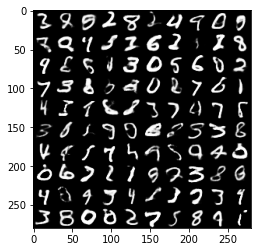

Negative log likelihood is 0.00826, divergence loss is 0.21866
Negative log likelihood is 0.00833, divergence loss is 0.20500
Negative log likelihood is 0.00761, divergence loss is 0.19937
Negative log likelihood is 0.00878, divergence loss is 0.20740
Negative log likelihood is 0.00754, divergence loss is 0.22205


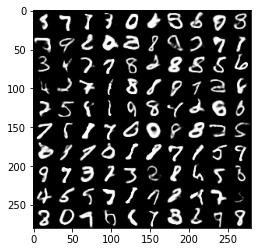

Negative log likelihood is 0.00822, divergence loss is 0.22381
Negative log likelihood is 0.00880, divergence loss is 0.23214
Negative log likelihood is 0.00781, divergence loss is 0.21791
Negative log likelihood is 0.00849, divergence loss is 0.21632
Negative log likelihood is 0.00809, divergence loss is 0.23379


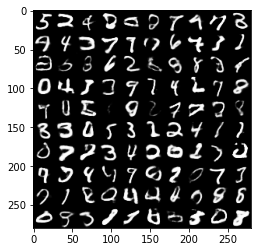

Negative log likelihood is 0.00773, divergence loss is 0.20559
Negative log likelihood is 0.00819, divergence loss is 0.22489
Negative log likelihood is 0.00819, divergence loss is 0.20598
Negative log likelihood is 0.00801, divergence loss is 0.21142
Negative log likelihood is 0.00774, divergence loss is 0.21036


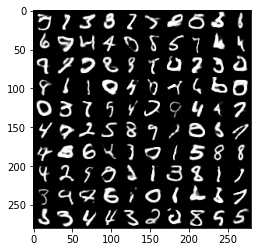

Negative log likelihood is 0.00769, divergence loss is 0.21912
Negative log likelihood is 0.00724, divergence loss is 0.22183
Negative log likelihood is 0.00780, divergence loss is 0.20913
Negative log likelihood is 0.00800, divergence loss is 0.21063
Negative log likelihood is 0.00792, divergence loss is 0.21754


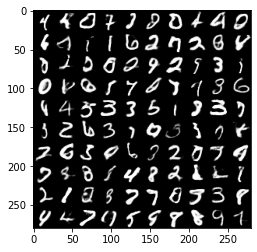

Negative log likelihood is 0.00807, divergence loss is 0.21029
Negative log likelihood is 0.00790, divergence loss is 0.21410
Negative log likelihood is 0.00770, divergence loss is 0.20261
Negative log likelihood is 0.00803, divergence loss is 0.21051
Negative log likelihood is 0.00769, divergence loss is 0.20555


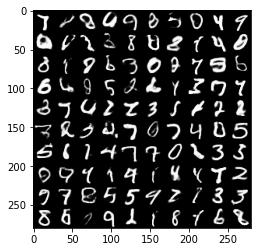

Negative log likelihood is 0.00813, divergence loss is 0.21046
Negative log likelihood is 0.00757, divergence loss is 0.21387
Negative log likelihood is 0.00712, divergence loss is 0.22427
Negative log likelihood is 0.00778, divergence loss is 0.21298
Negative log likelihood is 0.00770, divergence loss is 0.20792


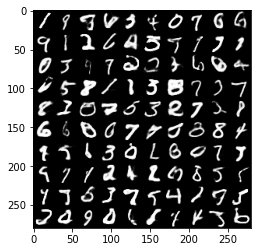

Negative log likelihood is 0.00728, divergence loss is 0.21087
Negative log likelihood is 0.00763, divergence loss is 0.21601
Negative log likelihood is 0.00715, divergence loss is 0.20934
Negative log likelihood is 0.00744, divergence loss is 0.21104
Negative log likelihood is 0.00740, divergence loss is 0.20864


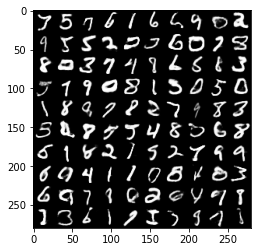

Negative log likelihood is 0.00767, divergence loss is 0.20784
Negative log likelihood is 0.00676, divergence loss is 0.20733
Negative log likelihood is 0.00787, divergence loss is 0.21531
Negative log likelihood is 0.00743, divergence loss is 0.22929
Negative log likelihood is 0.00676, divergence loss is 0.22258


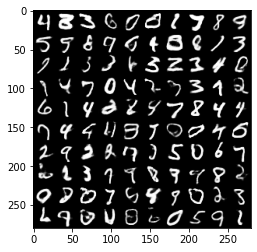

Negative log likelihood is 0.00766, divergence loss is 0.20221
Negative log likelihood is 0.00796, divergence loss is 0.20321
Negative log likelihood is 0.00661, divergence loss is 0.21378
Negative log likelihood is 0.00766, divergence loss is 0.21931
Negative log likelihood is 0.00711, divergence loss is 0.21334


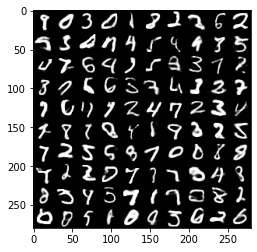

Negative log likelihood is 0.00718, divergence loss is 0.20176
Negative log likelihood is 0.00694, divergence loss is 0.22526
Negative log likelihood is 0.00661, divergence loss is 0.20972
Negative log likelihood is 0.00694, divergence loss is 0.22353
Negative log likelihood is 0.00723, divergence loss is 0.24004


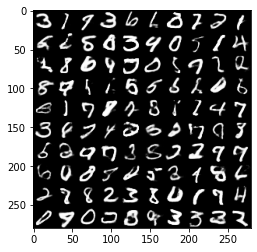

Negative log likelihood is 0.00723, divergence loss is 0.20314
Negative log likelihood is 0.00720, divergence loss is 0.21430
Negative log likelihood is 0.00754, divergence loss is 0.21266
Negative log likelihood is 0.00684, divergence loss is 0.22404
Negative log likelihood is 0.00712, divergence loss is 0.20721


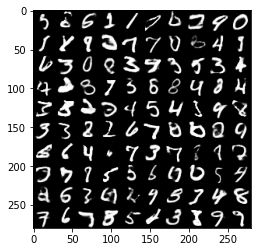

Negative log likelihood is 0.00717, divergence loss is 0.22504
Negative log likelihood is 0.00686, divergence loss is 0.21407
Negative log likelihood is 0.00720, divergence loss is 0.19032
Negative log likelihood is 0.00696, divergence loss is 0.21836
Negative log likelihood is 0.00643, divergence loss is 0.22241


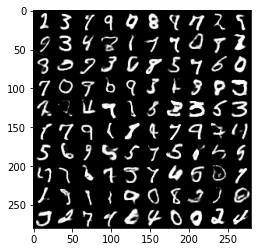

Negative log likelihood is 0.00643, divergence loss is 0.20793
Negative log likelihood is 0.00675, divergence loss is 0.21412
Negative log likelihood is 0.00721, divergence loss is 0.22073
Negative log likelihood is 0.00659, divergence loss is 0.20415
Negative log likelihood is 0.00683, divergence loss is 0.21785


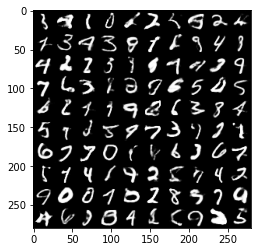

Negative log likelihood is 0.00679, divergence loss is 0.21348
Negative log likelihood is 0.00740, divergence loss is 0.21333
Negative log likelihood is 0.00660, divergence loss is 0.21457
Negative log likelihood is 0.00635, divergence loss is 0.21666
Negative log likelihood is 0.00628, divergence loss is 0.22135


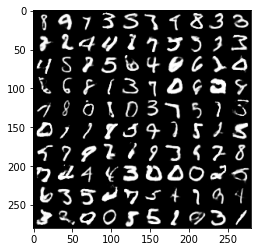

Negative log likelihood is 0.00639, divergence loss is 0.21751
Negative log likelihood is 0.00683, divergence loss is 0.21488
Negative log likelihood is 0.00661, divergence loss is 0.20154
Negative log likelihood is 0.00625, divergence loss is 0.19615


In [161]:
jrd_model = trainInfoVAE(mnist_train, 
                         divergence_func=matrixJRDivergence, 
                         tradeoff=0.1,
                         z_dim=z_dim, 
                         n_epochs=40)

In [162]:
## gather train data to train svm 
def gatherMNISTData(model):
    test_batch_size = 500
    mnist_test = torch.utils.data.DataLoader(
        MNIST("./tmp/MNIST", train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])),
        batch_size=test_batch_size, shuffle=True, num_workers=3,
        pin_memory=True
    )
    z_list, label_list = [], []
    for i in range(100):
        batch_x, batch_y = iter(mnist_test).next()
        batch_x = Variable(batch_x, requires_grad=False).cuda()
        z = model.encoder(batch_x)
        z_list.append(z.cpu().data.numpy())
        label_list.append(batch_y.numpy())
    z_train = np.concatenate(z_list, axis=0)
    label_train = np.concatenate(label_list)

    ## gather test data

    test_batch_size = 500
    mnist_test = torch.utils.data.DataLoader(
        MNIST("./tmp/MNIST", train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])),
        batch_size=test_batch_size, shuffle=True, num_workers=3,
        pin_memory=True
    )
    z_list, label_list = [], []
    for i in range(20):
        batch_x, batch_y = iter(mnist_test).next()
        batch_x = Variable(batch_x, requires_grad=False).cuda()
        z = model.encoder(batch_x)
        z_list.append(z.cpu().data.numpy())
        label_list.append(batch_y.numpy())
    z_test = np.concatenate(z_list, axis=0)
    label_test = np.concatenate(label_list)
    return (z_train, label_train), (z_test, label_test)

In [163]:
mmd_train_data, mmd_test_data = gatherMNISTData(mmd_model)

jrd_train_data, jrd_test_data = gatherMNISTData(jrd_model)


In [164]:
## train an svm classifier
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

def testClassifier(train_data, test_data):
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(train_data[0], train_data[1])

    pred_label = clf.predict(test_data[0])
    acc = np.mean(pred_label == test_data[1])

    print('test accuracy {: 5f}'.format(acc))

In [165]:
testClassifier(mmd_train_data, mmd_test_data)

test accuracy  0.979700


In [166]:
testClassifier(jrd_train_data, jrd_test_data)

test accuracy  0.982600
